# Nucleation of Fe in Fe-FeO liquid

This notebook outlines the nucleation calculation and shows how Figure 6 is produced.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import feo_thermodynamics

## FeO nucleation
We have the ability to calculate $g^{sl}$ explicitly
as a function of T, P and x (given some assumptions about what happens to O)
and can use classical nucleation theory as follows:

$$ \Delta G = 4/3 \pi r^3 g^{sl} + 4 \pi r^2 \gamma,$$

$$ r_c = \frac{-2 \gamma}{g^{sl}}, $$

(negative $r_c$ implies $g^{sl}$ is positive and we are above the liquidus.)

$$ \Delta G_c = \frac{16 \pi \gamma^3}{{3 g^{sl}}^2} $$

and 

$$ I = I_0 \exp \left[\frac{-\Delta G_c}{k_B T}\right] $$

or

$$ \tau_v = \frac{1}{2 I_0} \exp \left[\frac{\Delta G_c}{k_B T}\right] $$

approximations (beyond the thermodynamic model being right) are that the forward
and backwards reaction rates at the top of the barrier are the same, that $\gamma$
can be taken as a constant, that the crystalizing solid can be described by the bulk
thermodynamics, and that the neucli are spherical.

For an FeO liquid we can calculate the energy of solid HCP Fe and a liquid of any
oxygen content. We can then write:

$$g^{sl} = p g^{solid} + q g(x_p)^{liquid} - (p+q) g(x_i)^{liquid} $$

Where $(p+q)$ moles of liquid of composition $x_i$ freeze to form $p$ moles of HCP iron and 
$q$ moles of residual liquid of composition $x_p$. $p$ can be calculated from the volume of the
critical radius and the molar volume of the solid and $x_i$ is known. The difficulty is 
calculating $q$ and $x_p$. Note also that the volume of the solid and the two liquids differ, 
so that we need to include a PV term, but this is already included in the free energy calculation.

One approach is to say that as the critical nucleus forms the ejected oxygen becomes well mixed
in a macoscopic system. In this case $g(x_p)^{liquid} = g(x_i)^{liquid}$ and:

$$g^{sl} = g^{solid} - g(x_i)^{liquid} $$

In this approach $g(x_i)^{liquid}$ should be the chemical potential of Fe in the liquid (at $x_i$)
so we do not erroniously count the energy of the oxygen. We are essentially counting the energy
difference of the iron atoms in the well mixed liquid and the same atoms in the solid critical nucleus.

The following uses parameters from Davies et al. but thermodynamics from Komabayashi. We outline the 
equations as functions and plot the results as a function of temperature and composition.

In [2]:
def well_mixed_nucleation(gamma, gsl):
    """
    Calculate CNT parameters assuming pure phase or well mixed liquid
    
    gamma: surface energy (J m^-2)
    gsl: difference between free energy of solid and liquid (J m^-3)
    i0: pre-factor / attempt rate (s^-1 m^-3)
    
    if t > melting temperature, returns np.nan
    
    returns critical radii (in m), free energy barrier (in J), 
    nucleation rate (s^-1 m^3), and waiting time (s m^3)
    """
    # rc
    rc = -2*gamma / gsl
    mask = rc<=0.0 # negative radius is > Tm
    rc[mask] = np.nan
    
    # gc
    gc = (16.0 * np.pi * gamma**3) / (3.0 * gsl**2) # in J?
    gc[mask] = np.nan
    
    return rc, gc
    

In [3]:
def nucleation_rate(t, i0, gc):
    """
    Calculate nucleation rate for CNT given free energy at critical radius
    
    t: temperature (in K)
    i0: pre-factor / attempt rate (s^-1 m^-3)
    gc: free energy of critical radius (J)
    
    returns I (in s^-1 m^-3)
    """
    kb = 1.38064852E-23
    # nuc rate
    i = i0 * np.exp(-gc / (t * kb))
    return i

def waiting_time(t, prefac, gc):
    """
    Calculate waiting time for CNT given free energy at critical radius
    prefac: pre-factor / attempt rate (s m^3) [NB: inverse of i0 above!!!]
    gc: free energy of critical radius (J)
    
    returns tauv (in s m3)
    """
    # FIXME: this is likly to overflow in the exp, even if we precompute
    # prefac = 1/(2 i0). Break up the exp bit?
    kb = 1.38064852E-23
    
    # waiting time
    tauv = prefac*np.exp(gc / (t * kb))
    return tauv

In [4]:
def well_mixed_gsl(x, p, t):
    """
    Free energy change when making solid Fe in liquid FeO
    
    Assumes no O in solid, ideal mixing in liquid...
    
    """
    # All in J/mol
    _, g_fe, _ = feo_thermodynamics.solid_free_energies(x, p, t)
    g_lq = feo_thermodynamics.fe_liquid_chemical_potential(x, p, t)
    _, mol_vol_solid, _ = feo_thermodynamics.solid_molar_volume(1.0, p, t)
    _, partial_mol_vol_liquid, _ = feo_thermodynamics.liquid_molar_volume(1.0, p, t)
    g_sl = g_fe - g_lq # J/mol
    
    g_sl = g_sl  / (mol_vol_solid * 1.0E-6) # J / m^3 of solid
    return g_sl

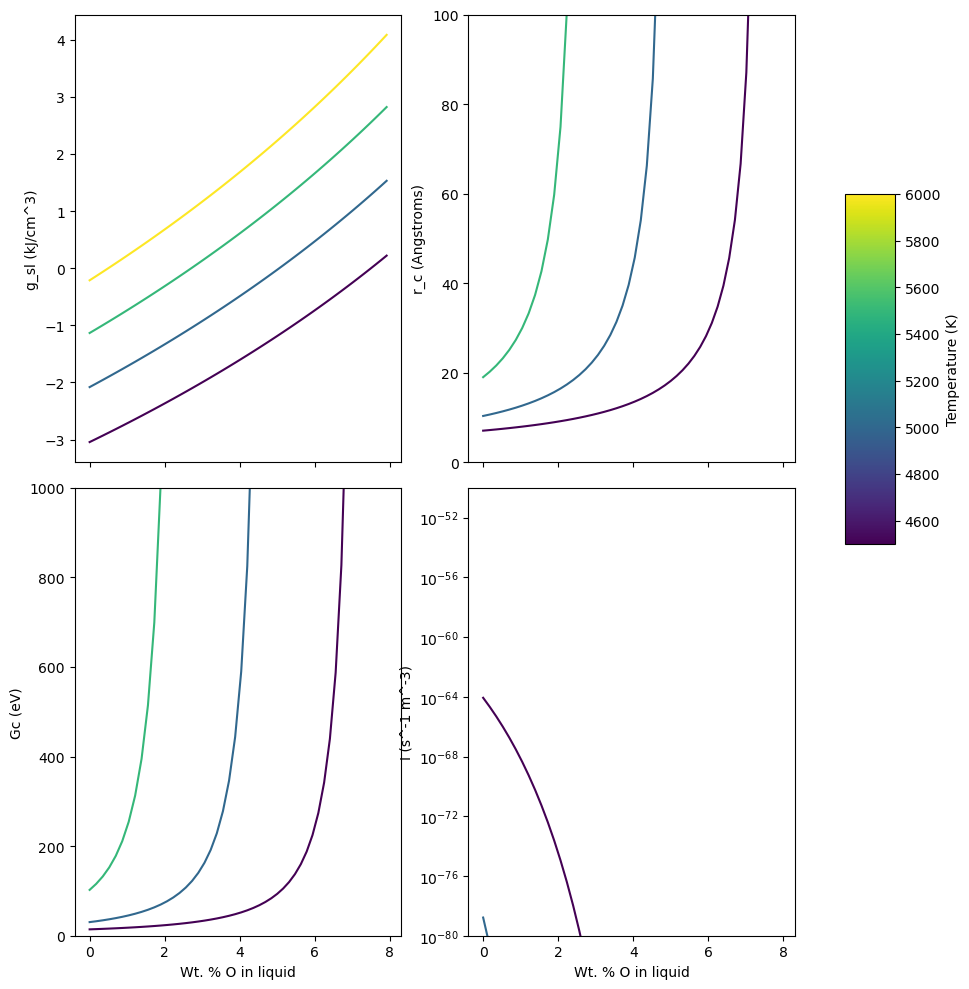

In [5]:
p = 330 # GPa
x = np.linspace(1.0, 0.7) # mol frac Fe
ts = np.array([6000, 5500, 5000, 4500])
gamma = 1.08 # J/m^2
i0 = 0.71E-48 # s^-1 m^-3

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,10))
cmap=matplotlib.cm.ScalarMappable(cmap='viridis')
cmap.set_clim(vmin=min(ts), vmax=max(ts))


for t in ts:
    
    # g_sl
    g_sl  = well_mixed_gsl(x, p, t)
    
    ax[0,0].plot(feo_thermodynamics.mass_percent_o(x), g_sl/(1000*1.0E6), # kJ/cm^3
            color=cmap.to_rgba(t))

    
    # nuc params
    rc, gc = well_mixed_nucleation(gamma, g_sl)
    i = nucleation_rate(t, i0, gc)

    ax[0,1].plot(feo_thermodynamics.mass_percent_o(x), rc/1E-10,
            color=cmap.to_rgba(t))

    ax[1,0].plot(feo_thermodynamics.mass_percent_o(x), 
               gc*6.242e+18, color=cmap.to_rgba(t))
    
    ax[1,1].plot(feo_thermodynamics.mass_percent_o(x), 
               i, color=cmap.to_rgba(t)) 

ax[0,0].set_ylabel('g_sl (kJ/cm^3)')  
ax[0,1].set_ylabel('r_c (Angstroms)')
ax[0,1].set_ylim(0.0, 100.0)
ax[1,0].set_ylabel('Gc (eV)')
ax[1,0].set_ylim(0.0, 1000.0)

ax[1,1].set_ylabel('I (s^-1 m^-3)')
ax[1,1].set_yscale('log')
ax[1,1].set_ylim(1.0E-80,1.0E-50)
ax[1,0].set_xlabel('Wt. % O in liquid')
ax[1,1].set_xlabel('Wt. % O in liquid')



fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.45, 0.05, 0.35])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Temperature (K)')
plt.show()

19.0340565254156
nan
nan
nan


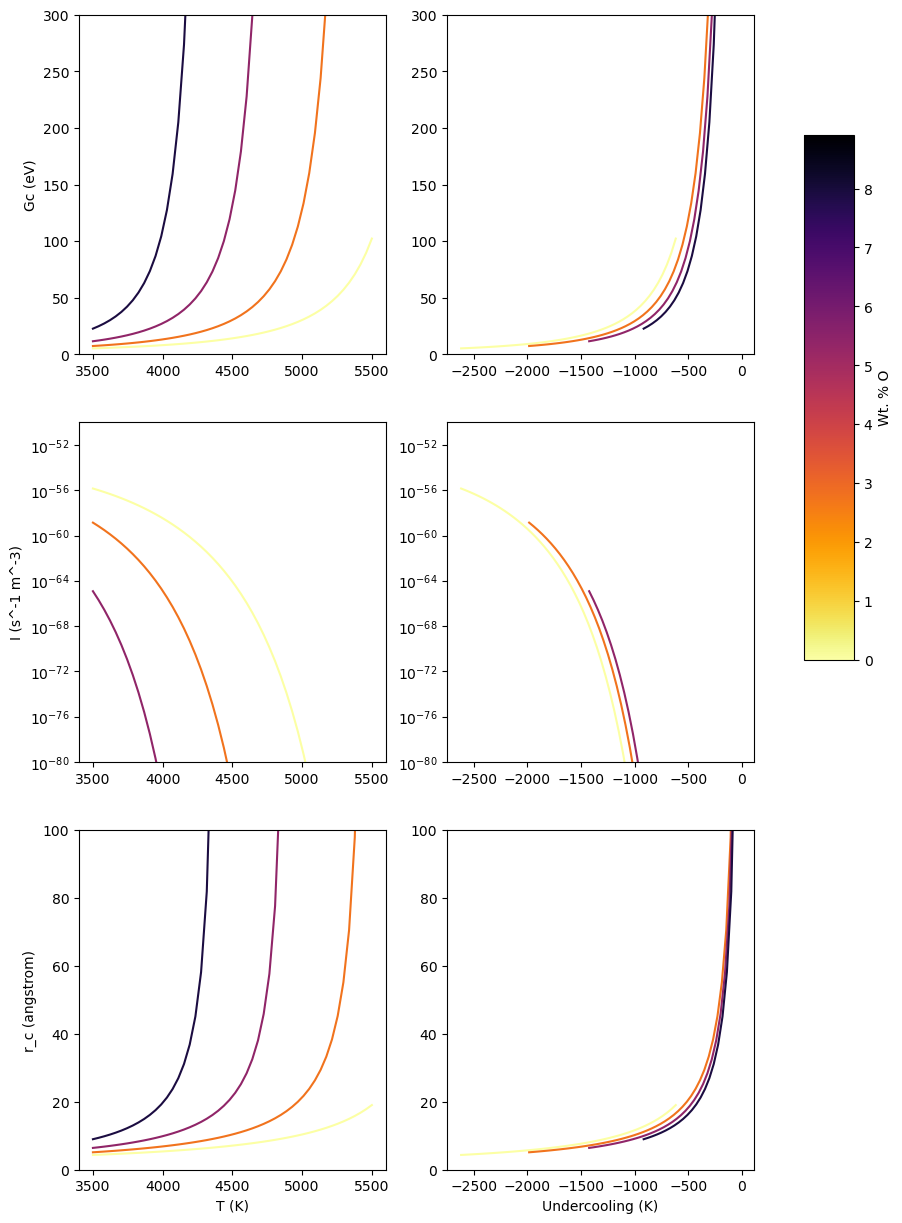

In [6]:
p = 330 # GPa
xs = np.array([1.0, 0.9, 0.8, 0.7]) # mol frac Fe
ts = np.linspace(3500, 5500)
gamma = 1.08 # J/m^2
i0 = 0.71E-48 # s^-1 m^-3

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,15))

cmap=matplotlib.cm.ScalarMappable(cmap='inferno_r')
cmap.set_clim(vmin=feo_thermodynamics.mass_percent_o(max(xs)), 
              vmax=feo_thermodynamics.mass_percent_o(min(xs))+1.0)

for x in xs:
    g_sl = np.zeros_like(ts)
    t_liquidus = feo_thermodynamics.find_liquidus(x, p)
    for i, t in enumerate(ts):
        g_sl[i]  = well_mixed_gsl(x, p, t)
        
    # nuc params
    rc, gc = well_mixed_nucleation(gamma, g_sl) 
    i = nucleation_rate(ts, i0, gc)
    
    ax[0,0].plot(ts, gc*6.242e+18, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    ax[0,1].plot(ts-t_liquidus, gc*6.242e+18, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))

    ax[1,0].plot(ts, 
               i, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    ax[1,1].plot(ts-t_liquidus, 
               i, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    
    ax[2,0].plot(ts, rc/1E-10, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    ax[2,1].plot(ts-t_liquidus, rc/1E-10, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    print(rc[-1]/1E-10)
    
ax[0,0].set_ylabel('Gc (eV)')
ax[2,0].set_xlabel('T (K)')
ax[2,0].set_ylabel('r_c (angstrom)')
ax[0,0].set_ylim(0, 300)
ax[0,1].set_ylim(0, 300)
ax[2,1].set_xlabel('Undercooling (K)')
ax[1,0].set_ylabel('I (s^-1 m^-3)')
ax[1,0].set_ylim(1.0E-80, 1.0E-50)
ax[1,1].set_ylim(1.0E-80,1.0E-50)
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[2,0].set_ylim(0, 100)
ax[2,1].set_ylim(0, 100)

#fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.45, 0.05, 0.35])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Wt. % O')
plt.show()



## Figure for manuscript

Now we just need a figure to show the above for the manuscript. We'll use the
nucleation python module to do the calculations (which is just like the
functions above, but reusable). This produces Figure 6.

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import nucleation

<>:56: SyntaxWarning: invalid escape sequence '\c'
<>:56: SyntaxWarning: invalid escape sequence '\c'
/var/folders/ml/v4gt_6r93gs7rsj_qmkwd3q40000gn/T/ipykernel_20155/1222244392.py:56: SyntaxWarning: invalid escape sequence '\c'
  axrr.set_xlabel('Wetting angle, $\\theta$ ($^{\circ}$)')


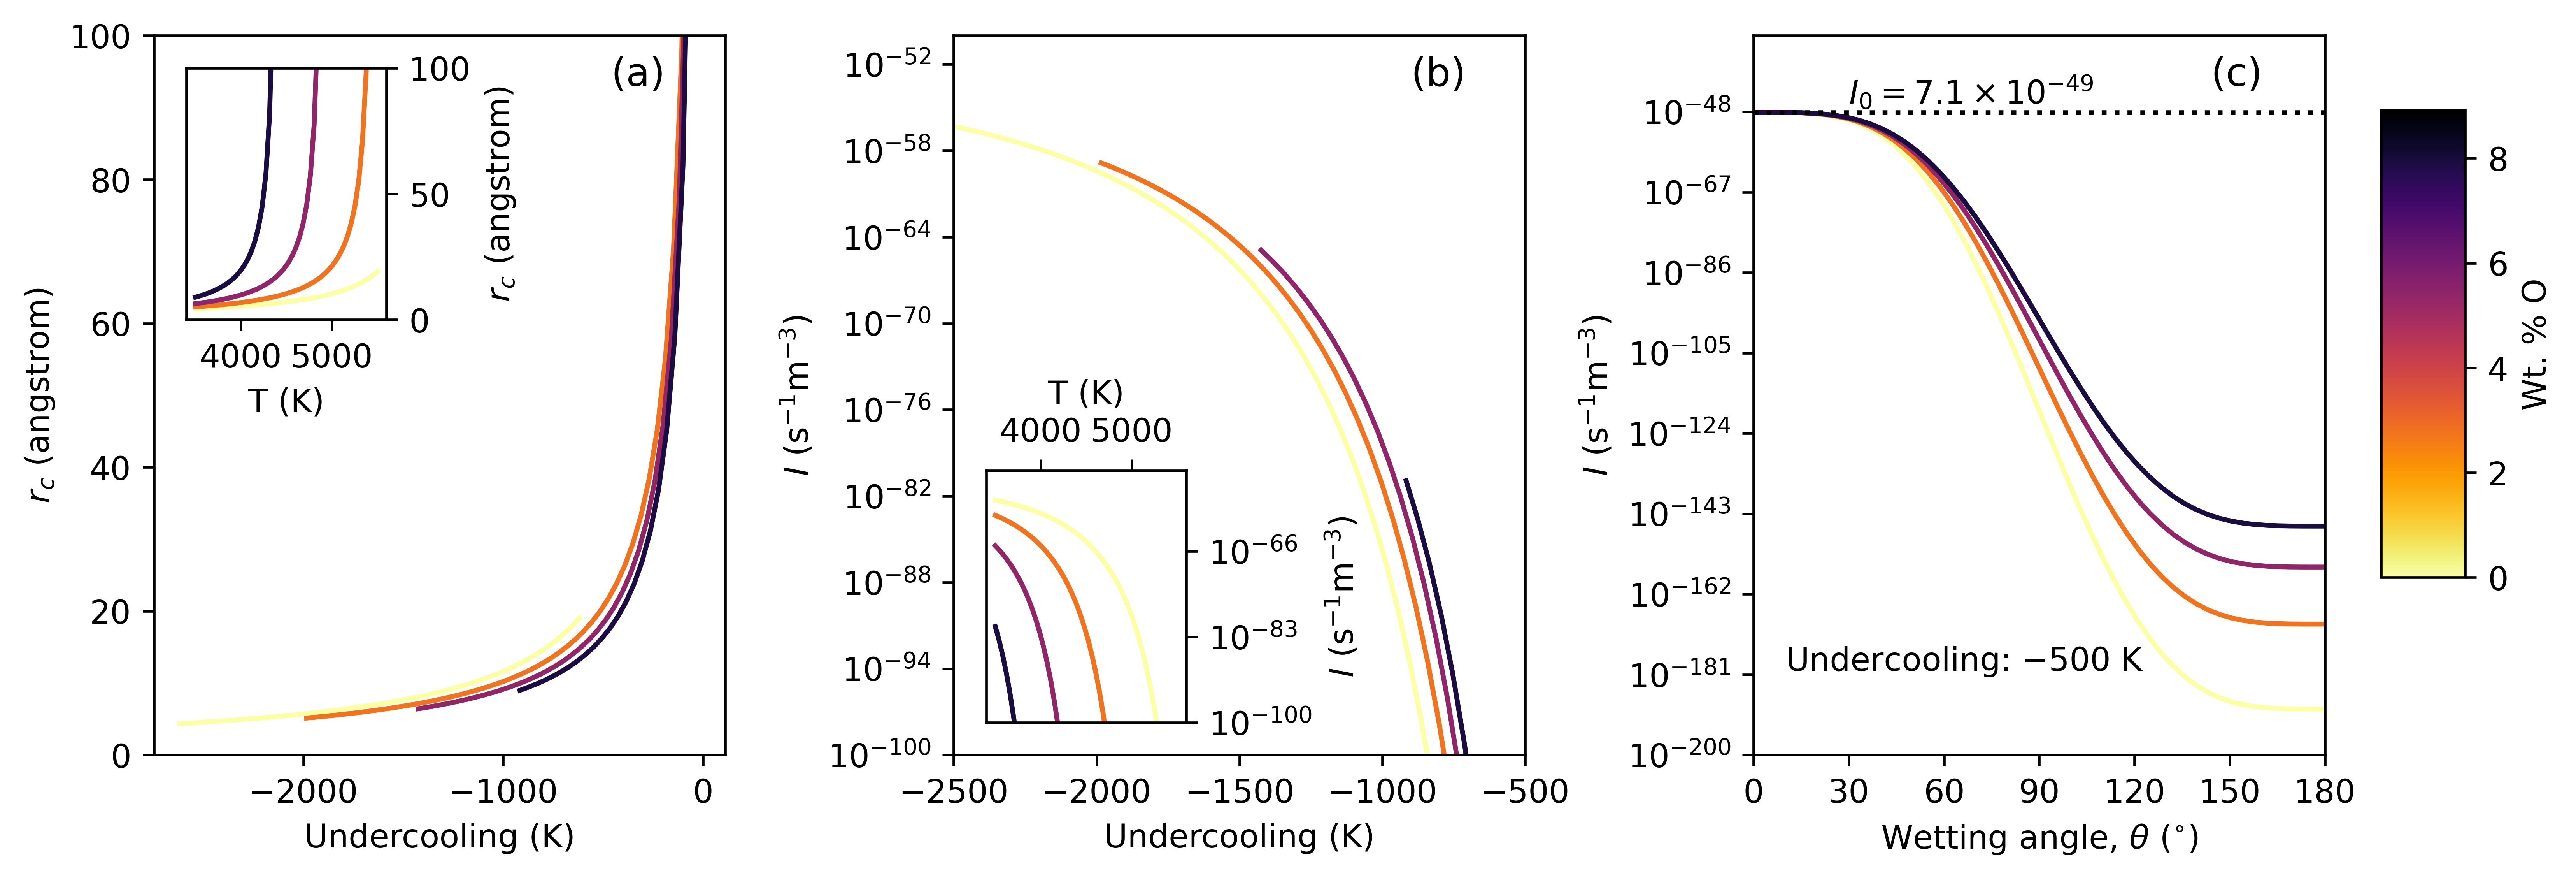

In [8]:
p = 330 # GPa
xs = np.array([1.0, 0.9, 0.8, 0.7]) # mol frac Fe
ts = np.linspace(3500, 5500)
gamma = 1.08 # J/m^2
i0 = 0.71E-48 # s^-1 m^-3
dt = -500
thetas = np.linspace(0.0, 180.0)

# Our colormap - scale of mass percent O
cmap=matplotlib.cm.ScalarMappable(cmap='inferno_r')
cmap.set_clim(vmin=feo_thermodynamics.mass_percent_o(max(xs)), 
              vmax=feo_thermodynamics.mass_percent_o(min(xs))+1.0)


fig, (axl, axr, axrr) = plt.subplots(ncols=3, nrows=1, figsize=(12,4), dpi=600, 
                               gridspec_kw={'wspace':0.4})

axl_ins = inset_axes(axl, width="35%", height="35%", loc=2, borderpad=1)
axr_ins = inset_axes(axr, width="35%", height="35%", loc=3, borderpad=1)


for x in xs:
    t_liquidus = feo_thermodynamics.find_liquidus(x, p) 
    rc_s = np.zeros_like(ts)
    i_s = np.zeros_like(ts)
    rc_s_het = np.zeros_like(ts)
    i_s_het = np.zeros_like(ts)
    for i, t in enumerate(ts):
        rc_s[i], i_s[i], _ = nucleation.calc_nucleation(x, p, t, gamma, i0)
    
    t = t_liquidus + dt
    for i, theta in enumerate(thetas):    
        rc_s_het[i], i_s_het[i], _ = nucleation.calc_nucleation(x, p, t, gamma, i0, theta=theta)
    axrr.plot(thetas, i_s_het, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    
    
    axr_ins.plot(ts, i_s, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    axr.plot(ts-t_liquidus, i_s, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    
    axl_ins.plot(ts, rc_s/1E-10, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    axl.plot(ts-t_liquidus, rc_s/1E-10, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))

axl.set_ylim(0, 100)
axl_ins.set_ylim(0,100)
axl_ins.yaxis.tick_right()
axl_ins.yaxis.set_label_position('right') 


axrr.set_ylim(1.0E-200, 1.0E-30)
axrr.set_yscale("log")
axrr.set_xlim(0.0, 180.0)
axrr.hlines(i0, 0.0, 180.0, ls=':', color='k')
axrr.text(30.0, i0*100, "$I_0 = 7.1\\times10^{-49}$")
axrr.text(10.0, 1.0E-180, f"Undercooling: ${dt}$ K")
axrr.set_ylabel('$I$ (s$^{-1}$m$^{-3}$)')
axrr.set_xlabel('Wetting angle, $\\theta$ ($^{\circ}$)')
axrr.set_xticks([0.0,30.0,60,90.0,120.0,150.0,180.0])

axr.set_ylim(1.0E-100, 1.0E-50)
axr.set_xlim(-2500, -500)
axr_ins.set_ylim(1.0E-100,1.0E-50)
axr.set_yscale("log")
axr_ins.set_yscale("log")
axr_ins.yaxis.tick_right()
axr_ins.xaxis.tick_top()
axr_ins.xaxis.set_label_position('top')
axr_ins.yaxis.set_label_position('right') 

axr_ins.set_xlabel('T (K)')
axl_ins.set_xlabel('T (K)')
axl.set_xlabel('Undercooling (K)')
axr.set_xlabel('Undercooling (K)')
axl.set_ylabel('$r_c$ (angstrom)')
axl_ins.set_ylabel('$r_c$ (angstrom)')
axr.set_ylabel('$I$ (s$^{-1}$m$^{-3}$)')
axr_ins.set_ylabel('$I$ (s$^{-1}$m$^{-3}$)')

cbar_ax = fig.add_axes([0.92, 0.3, 0.03, 0.5])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Wt. % O')

axl.annotate("(a)", xy=(0.8, 0.93), xycoords="axes fraction", fontsize='large')
axr.annotate("(b)", xy=(0.8, 0.93), xycoords="axes fraction", fontsize='large')
axrr.annotate("(c)", xy=(0.8, 0.93), xycoords="axes fraction", fontsize='large')
   
plt.show()